<a href="https://colab.research.google.com/github/liveness-detection-bangkit-team/liveness_ai/blob/main/blink_mobilenetv3small_ariel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke direktori dataset
train_dir = '/content/drive/MyDrive/datasets/datasets/train_blink_set'
test_dir = '/content/drive/MyDrive/datasets/datasets/test_blink_set'

In [ ]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1088 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


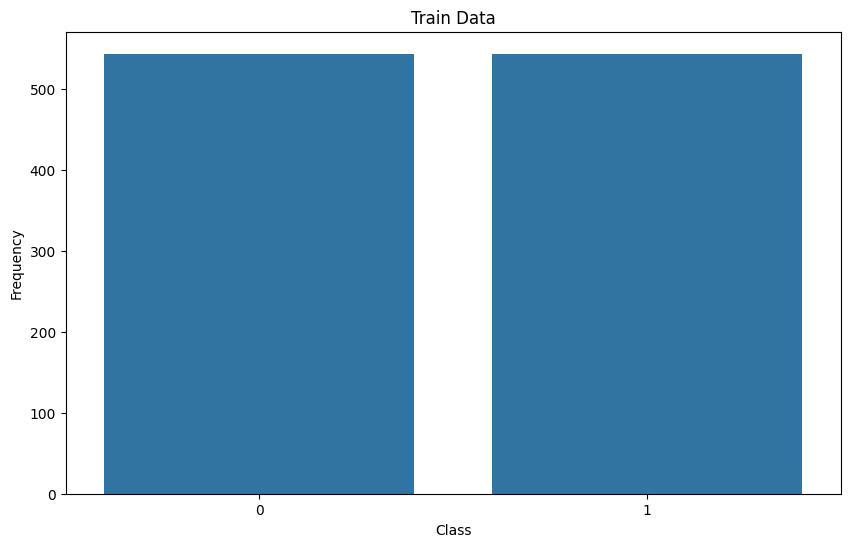

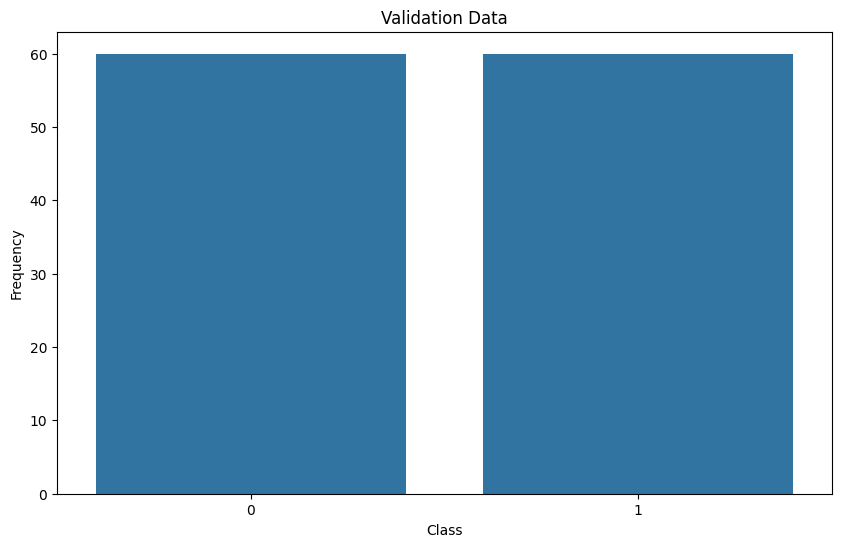

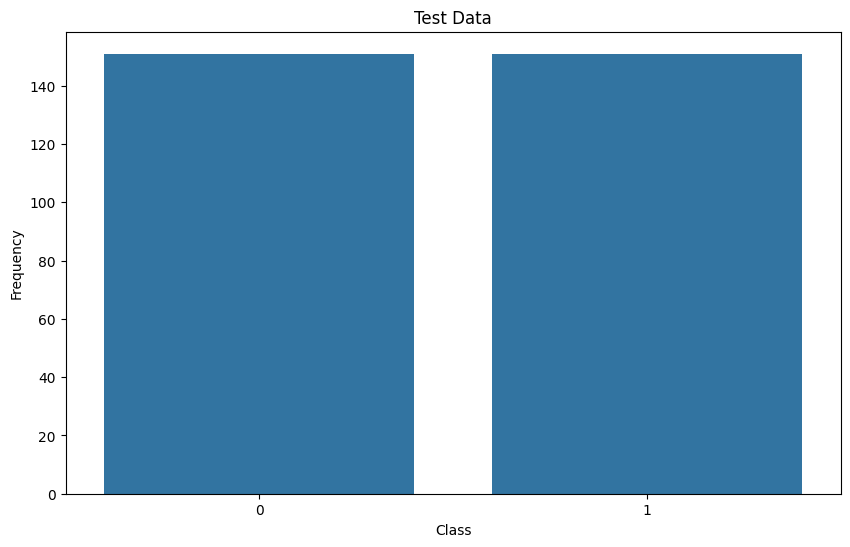

In [ ]:
from collections import Counter

# Get class indices and counts
train = train_generator.class_indices
train_count = train_generator.classes

test = test_generator.class_indices
test_count = test_generator.classes

val = validation_generator.class_indices
val_count = validation_generator.classes

# Calculate class frequencies
train_total_samples = len(train_count)
train_class_frequencies = {class_name: count for class_name, count in Counter(train_count).items()}

val_total_samples = len(val_count)
val_class_frequencies = {class_name: count for class_name, count in Counter(val_count).items()}

test_total_samples = len(test_count)
test_class_frequencies = {class_name: count for class_name, count in Counter(test_count).items()}



plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_class_frequencies.keys()), y=list(train_class_frequencies.values()))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Train Data')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(val_class_frequencies.keys()), y=list(val_class_frequencies.values()))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Validation Data')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_class_frequencies.keys()), y=list(test_class_frequencies.values()))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Test Data')
plt.show()

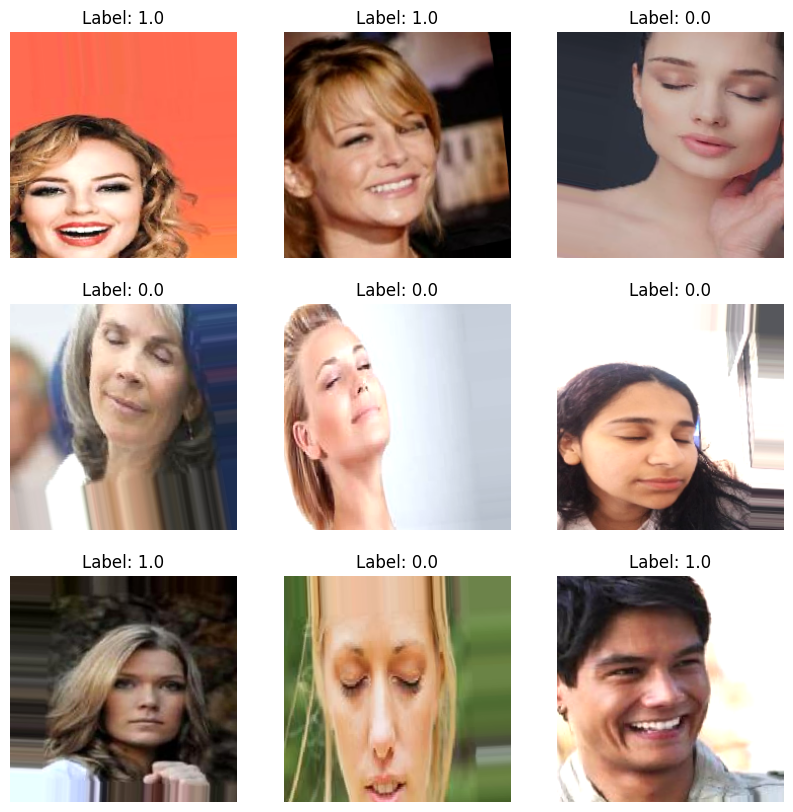

In [ ]:
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Images are in numpy format
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

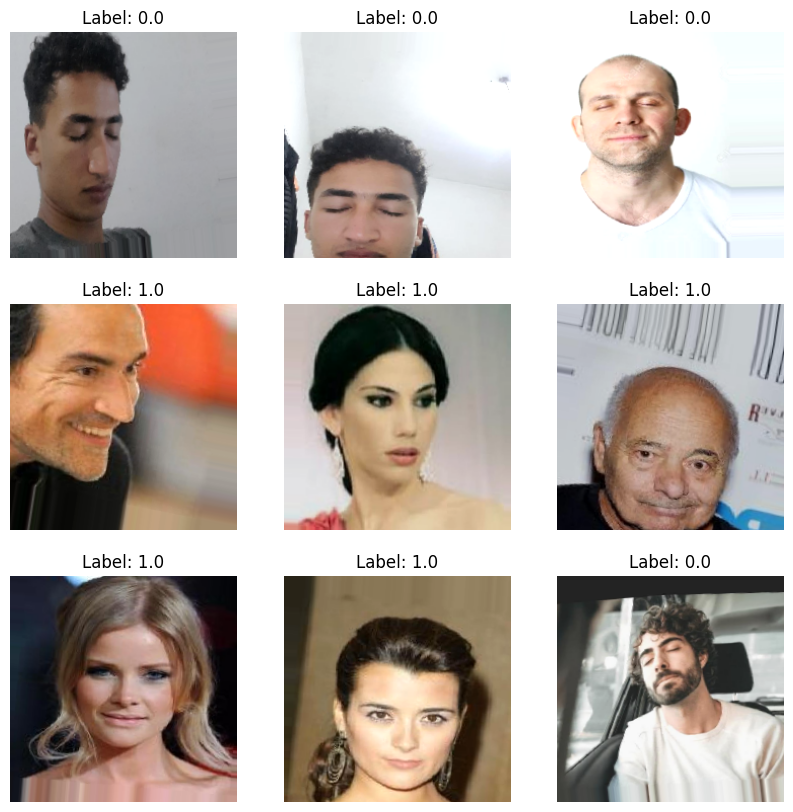

In [ ]:
images, labels = next(validation_generator)
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Images are in numpy format
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

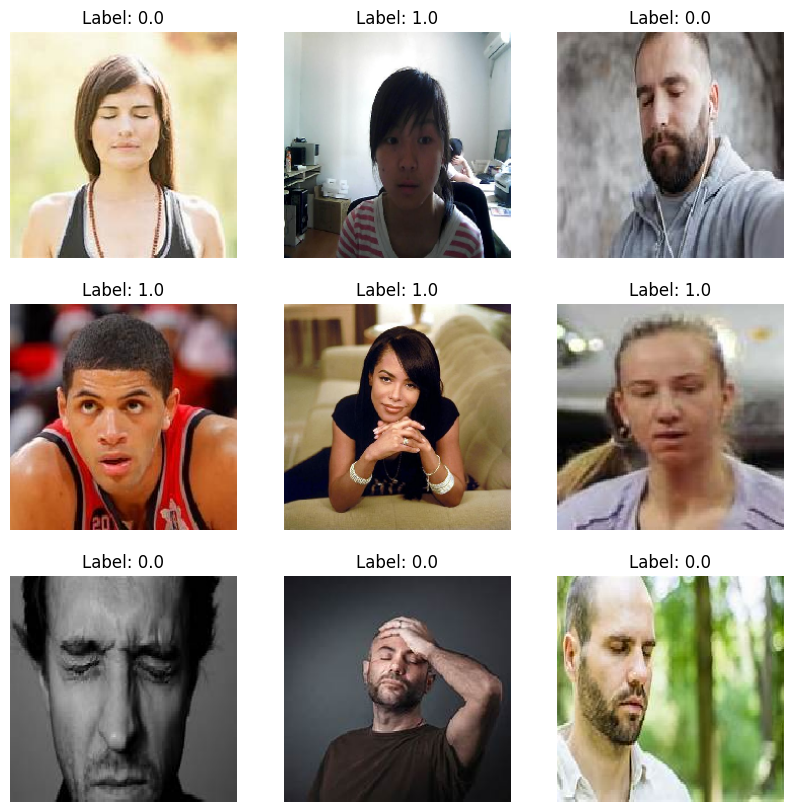

In [ ]:
images, labels = next(test_generator)
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Images are in numpy format
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

In [ ]:
IMAGE_SHAPE = (224, 224, 3)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
base_model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)  

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
base_model.trainable = False

inputs = tf.keras.Input(shape=IMAGE_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
inputs = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.bool)  # Thresholding for binary classification

        # Update true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_true), y_pred), self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(y_true, tf.logical_not(y_pred)), self.dtype)))

    def result(self):
        # Calculate precision and recall
        precision = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_positives)
        recall = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)

        # Calculate F1 score
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        return f1

    def reset_states(self):
        # Reset the true positives, false positives, and false negatives to zero
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
                  learning_rate=0.001,
                  beta_1 = 0.9,
                  beta_2 = 0.999,
                  weight_decay = 0.0
                ),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,087,089 (4.15 MB)

 Trainable params: 147,969 (578.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./blink_mobilenetv3_checkpoint_ariel1.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    )

history = model.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[early_stopping,checkpoint])

# Save model
model.save('/content/drive/MyDrive/Model/blink_mobilenetv3_ariel2.keras')

# Mengonversi model ke TFLite
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Model/blink_mobilenetv3_ariel2.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '/content/drive/MyDrive/Model/model_blink_ariel2.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/34 ━━━━━━━━━━━━━━━━━━━━ 9s 10s/step - accuracy: 0.6927 - loss: 0.5528 - precision_1: 0.6779 - recall_1: 0.6252 
Epoch 1: val_accuracy improved from -inf to 0.69167, saving model to ./blink_mobilenetv3_checkpoint_ariel1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 449s 11s/step - accuracy: 0.6975 - loss: 0.5473 - precision_1: 0.6845 - recall_1: 0.6323 - val_accuracy: 0.6917 - val_loss: 0.6347 - val_precision_1: 0.6211 - val_recall_1: 0.9833
Epoch 2/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8442 - loss: 0.3463 - precision_1: 0.8270 - recall_1: 0.9084
Epoch 2: val_accuracy improved from 0.69167 to 0.82500, saving model to ./blink_mobilenetv3_checkpoint_ariel1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 578ms/step - accuracy: 0.8454 - loss: 0.3443 - precision_1: 0.8287 - recall_1: 0.9067 - val_accuracy: 0.8250 - val_loss: 0.4137 - val_precision_1: 0.7532 - val_recall_1: 0.9667
Epoch 3/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8907 - loss: 0.2611 - precision_1: 0.8928 - reca

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Model/blink_mobilenetv3_ariel1.keras'

In [16]:
# Save model
model.save('/content/drive/MyDrive/Model_ariel/blink_mobilenetv3_ariel2.keras')

# Mengonversi model ke TFLite
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Model_ariel/blink_mobilenetv3_ariel2.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '/content/drive/MyDrive/Model_ariel/blink_mobilenetv3_ariel2.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp_ix47ose'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136760823613216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821801984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821802512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821796352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821801280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760825460368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821805680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821807968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821804272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821806736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367608232

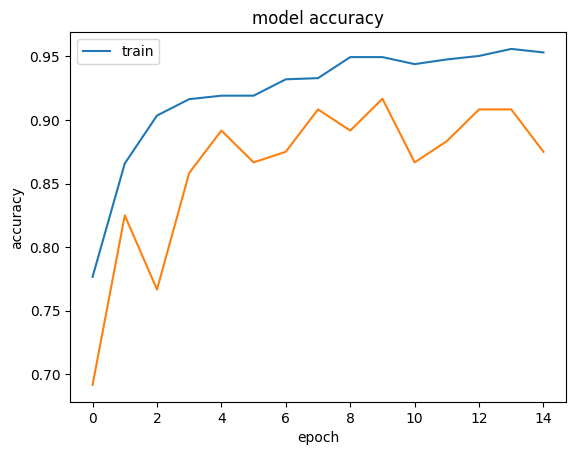

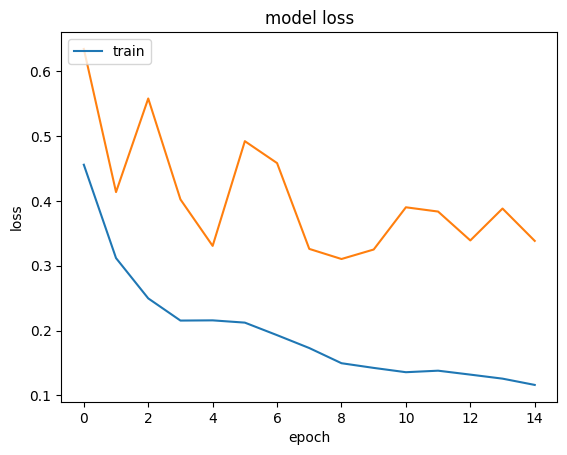

In [18]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()

    plt.show()

plot_loss_acc(history)

In [17]:
loaded_model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 188s 20s/step - accuracy: 0.5982 - loss: 1.2766 - precision_1: 0.9367 - recall_1: 0.2540


[1.2237446308135986, 0.612582802772522, 0.9047619104385376, 0.251655638217926]

In [19]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  157


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(
                  learning_rate=0.001,
                  beta_1 = 0.9,
                  beta_2 = 0.999,
                  weight_decay = 0.0
                ),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,087,089 (4.15 MB)

 Trainable params: 443,217 (1.69 MB)

 Non-trainable params: 643,872 (2.46 MB)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./blink_mobilenetv3_checkpoint_ariel1.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    )

history = model.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[early_stopping,checkpoint])



Epoch 1/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8565 - loss: 0.4182 - precision_2: 0.8910 - recall_2: 0.8209
Epoch 1: val_accuracy improved from -inf to 0.91667, saving model to ./blink_mobilenetv3_checkpoint_ariel1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 809ms/step - accuracy: 0.8588 - loss: 0.4110 - precision_2: 0.8921 - recall_2: 0.8245 - val_accuracy: 0.9167 - val_loss: 0.3093 - val_precision_2: 0.8571 - val_recall_2: 1.0000
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9455 - loss: 0.1437 - precision_2: 0.9488 - recall_2: 0.9433
Epoch 2: val_accuracy improved from 0.91667 to 0.92500, saving model to ./blink_mobilenetv3_checkpoint_ariel1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 627ms/step - accuracy: 0.9457 - loss: 0.1432 - precision_2: 0.9489 - recall_2: 0.9435 - val_accuracy: 0.9250 - val_loss: 0.2658 - val_precision_2: 0.8923 - val_recall_2: 0.9667
Epoch 3/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9589 - loss: 0.1116 - precision_2: 

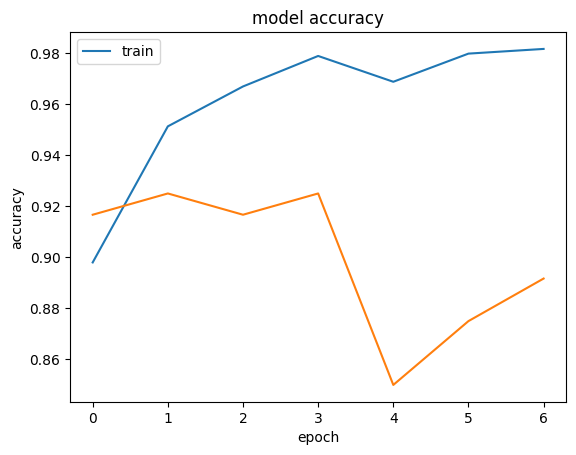

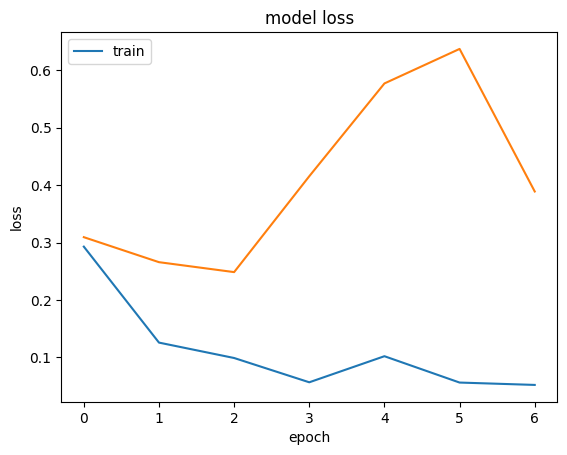

In [22]:


plot_loss_acc(history)

In [24]:
# Save model
model.save('/content/drive/MyDrive/Model_ariel/blink_mobilenetv3_ariel2.keras')

# Mengonversi model ke TFLite
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Model_ariel/blink_mobilenetv3_ariel2.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '/content/drive/MyDrive/Model_ariel/blink_mobilenetv3_ariel2.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp38vgo9mg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136760823613216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821801984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821802512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821796352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821801280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760825460368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821805680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821807968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821804272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136760821806736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367608232